# Importing Packages

In [251]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Importing  and Filtering the Data
## Training Data

In [252]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d %H:%M:%S')

data = pd.read_csv('data/transformed/Simples_Geração_de_Energia_Dia_data_nordeste.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday
data.head()

,value,date,year,month,day,hour,weekday
index,,,,,,,
2000-01-01 00:00:00,5350.7,2000-01-01 00:00:00,2000,1,1,0,5
2000-01-01 01:00:00,5190.9,2000-01-01 01:00:00,2000,1,1,1,5
2000-01-01 02:00:00,5069.5,2000-01-01 02:00:00,2000,1,1,2,5
2000-01-01 03:00:00,4895.0,2000-01-01 03:00:00,2000,1,1,3,5
2000-01-01 04:00:00,4780.6,2000-01-01 04:00:00,2000,1,1,4,5


## 2. Value over times

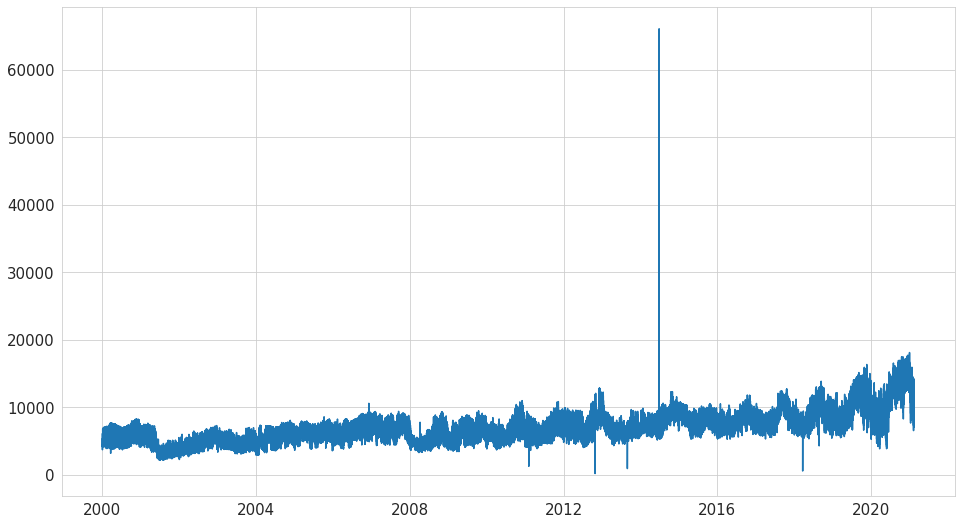

In [253]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(data['value'])

## 2. Test Data with one hundred first values

<AxesSubplot:ylabel='Density'>

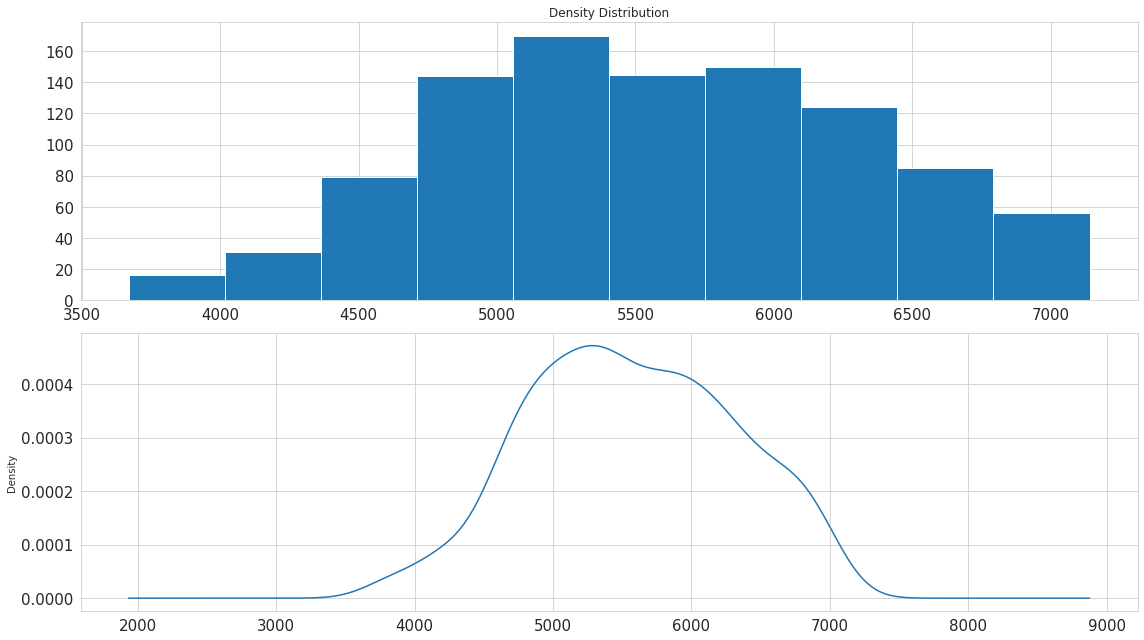

In [254]:
value = data['value'].head(1000)
plt.figure(tight_layout=True)
plt.subplot(211)
value.hist()
plt.title('Density Distribution')
plt.subplot(212)
value.plot(kind='kde')

## 2. Test Data with all values with another form

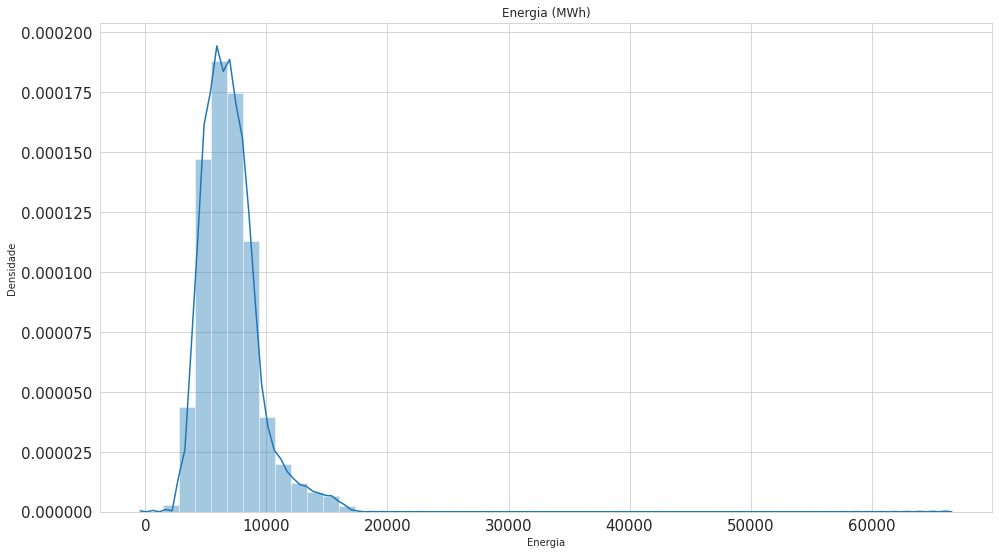

In [255]:
ax = sns.distplot(data['value'], kde=True)
ax.set(xlabel= 'Energia', ylabel='Densidade', title='Energia (MWh)')
plt.show()

## 2. Histogram

array([[<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'weekday'}>,
        <AxesSubplot:title={'center':'year'}>]], dtype=object)

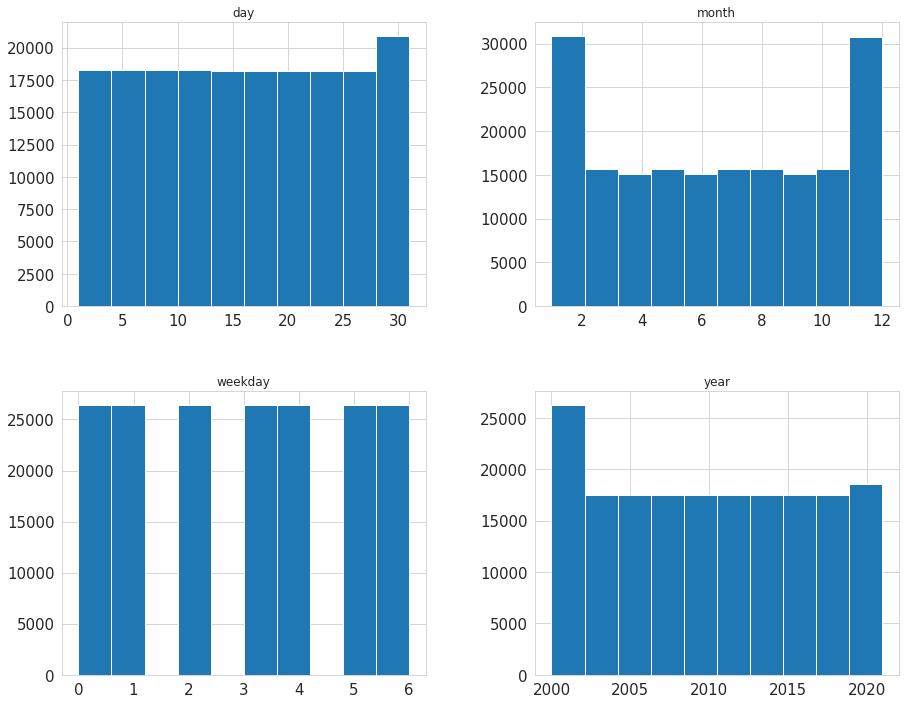

In [256]:
data.hist(grid=True, figsize=(15,12), column=['day', 'weekday', 'month', 'year'])

## 2. Box-plot

<AxesSubplot:title={'center':'value'}, xlabel='year'>

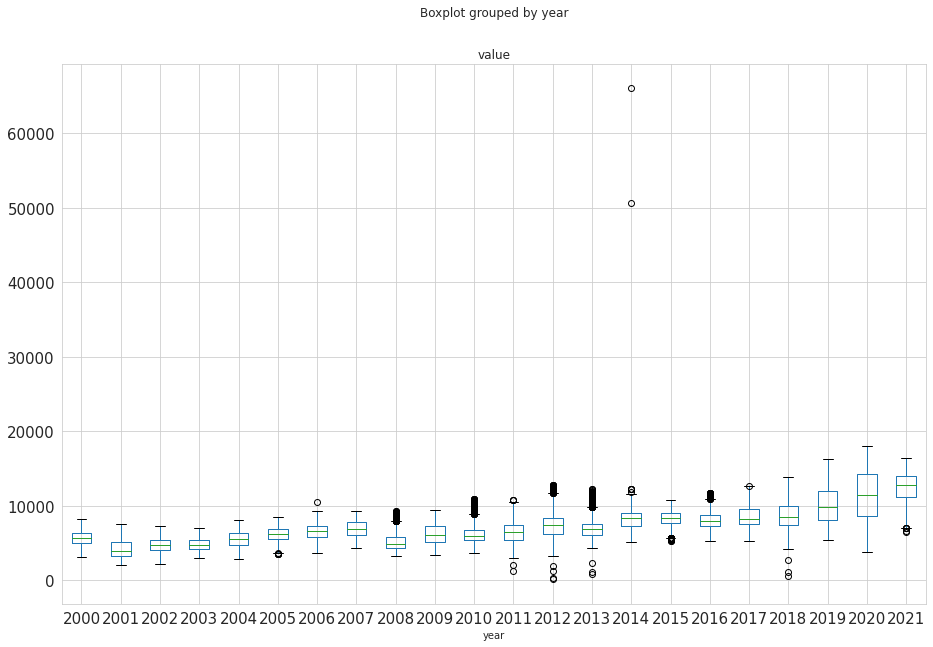

In [257]:
data.boxplot(figsize=(15,10), by='year', column='value')

## 3. Log transformation

None


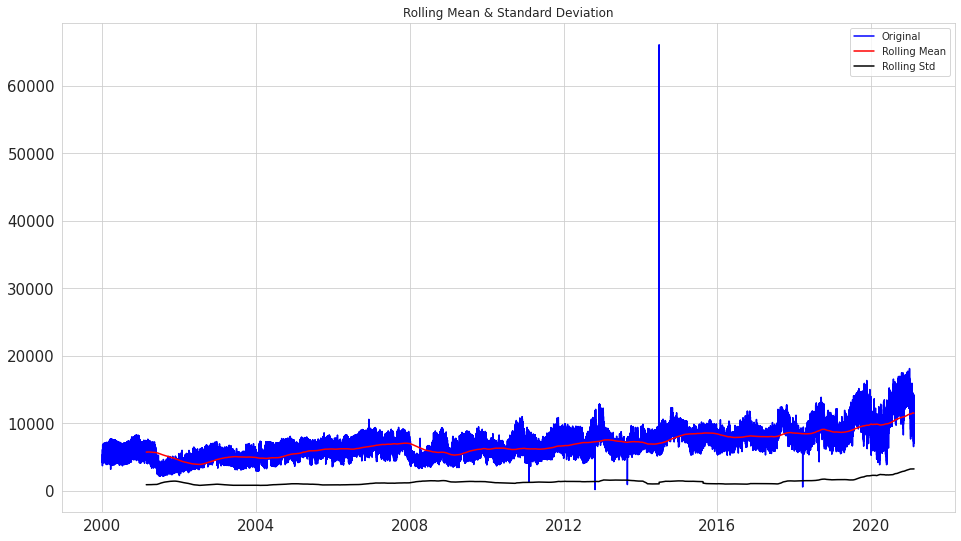

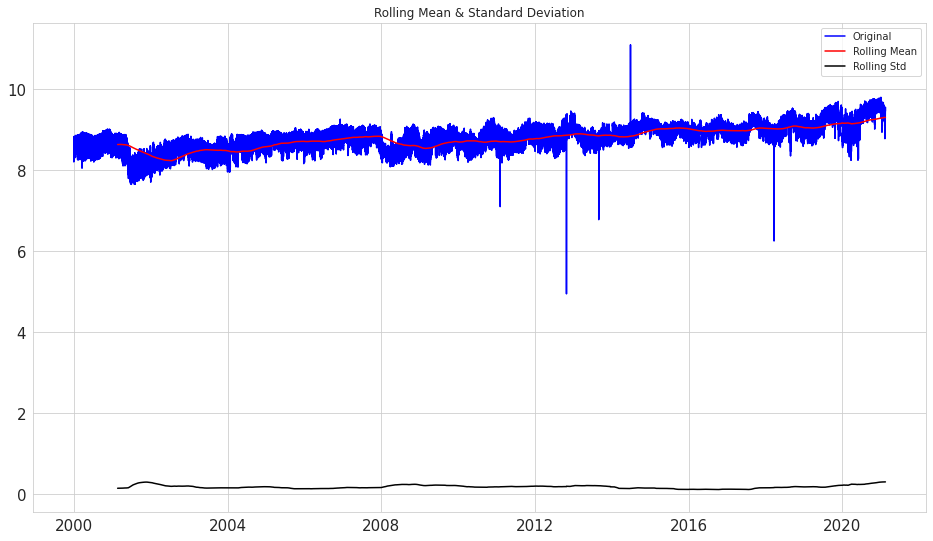

In [258]:
v_log = np.log(data['value'])
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
value = data['value']
print(pd.infer_freq(value.index))

def test_stationarity(timeseries, window_size=10000):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean()
    rolstd  = timeseries.rolling(window_size).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

test_stationarity(data['value'])

#Take first difference:
# data_diff = data['value'] - data['value'].shift()
# plt.plot(data_diff)
#
# data['value'] = data_diff.values
# data = data.replace([np.NaN, np.inf, -np.inf], 346.800)
# data.head()

test_stationarity(np.log(data['value']))

## 4. Decomposition

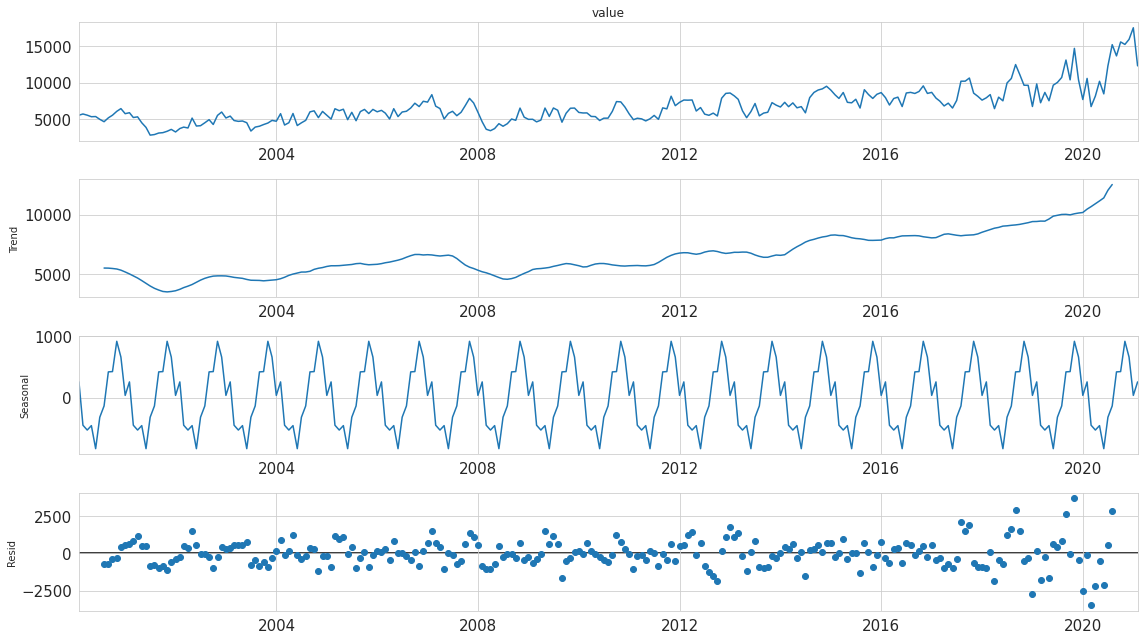

In [259]:
data.sort_index(inplace=True)
data.drop(['date', 'year', 'month', 'day', 'hour', 'weekday'],inplace=True,axis=1)

decomposition = sm.tsa.seasonal_decompose(data.value.asfreq('m'), model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

## 5. Test KPPS

In [260]:
sm.tsa.kpss(v_log)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


(146.29181766339644,
 0.01,
 79,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## 5. Test PP

In [261]:
pp(v_log)

Test Statistic,-31.954
P-value,0.000
Lags,79


## 5. Test Fuller

In [262]:
sm.tsa.adfuller(v_log)


(-9.190620325851267,
 2.1282418858814603e-15,
 79,
 184989,
 {'1%': -3.4303853501599706,
  '5%': -2.86155562429598,
  '10%': -2.566778316252235},
 -722465.6632596105)